In [1]:
import matplotlib.pyplot as plt
import numpy as np

from testcases import TestCase

from domains import Waveguide, ScattererShape, ScattererType

# First Experiment (H convergence)

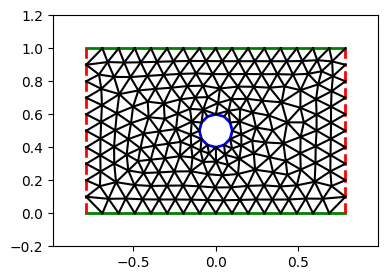

In [2]:
kappa_e = 8.
lambda_e = 2*np.pi/kappa_e
R = lambda_e
H = 1.
c = (0,0.5*H)
Domain = Waveguide(R=R,H=H)
Domain.add_scatterer( ScattererShape.CIRCLE, ScattererType.SOUND_SOFT, (c, 0.1*H))
Domain.generate_mesh(h_max=H/10)
Domain.plot_mesh()

In [3]:
from Trefft_tools import  TrefftzSpace
Nth = 3
th_0 = np.e/np.pi # no correct direction in the basis
#th_0= 0. # right direction in the basis
V = TrefftzSpace(Domain.Omega, Nth, {"Omega_i" : kappa_e , "Omega_e" : kappa_e}, th_0 )


In [4]:
from Trefft_tools import AssembleMatrix
N_modes = 15 #Number of modes for the DtN map
# "UWVF" parameters
a = 0.5
b = 0.5
d_1 = 0.5
d_2 = 0.5
A = AssembleMatrix(V, Domain.Edges, H, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
NDOF = A.shape[0]
print(f'{NDOF} degrees of freedom.\n Matrix with {np.count_nonzero(A.toarray())} non-zero entries from a total of {NDOF**2}.\n "fullness" ratio: {np.count_nonzero(A.toarray())/NDOF**2 * 100 : .2f}%')

1200 degrees of freedom.
 Matrix with 15444 non-zero entries from a total of 1440000.
 "fullness" ratio:  1.07%


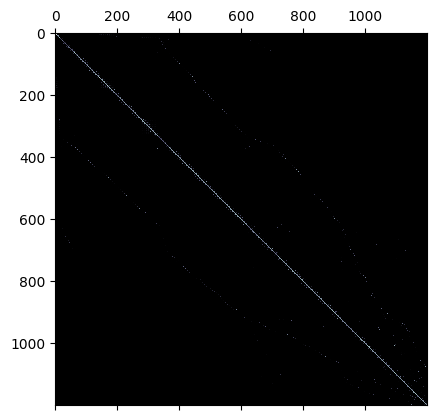

In [5]:
from checking_tools import plot_sparsity
plot_sparsity(A)

In [6]:
# Ncond = np.linalg.cond(A.toarray())
# Ncond

In [7]:
from Trefft_tools import AssembleGreenRHS, AssembleRHS
from exact_solutions import GreenFunctionModes, GreenFunctionImages

In [8]:
B = AssembleGreenRHS(V, Domain.Edges, kappa_e, H, a=a, y0=c[1], modes=True)
# t = 1
# B = AssembleRHS(V, Domain.Edges, kappa_e, H, d_2=d_2, t = t)

In [9]:
from Trefft_tools import TrefftzFunction
#this should be a "solve system"
from scipy.sparse.linalg import spsolve 
A = A.tocsc()
DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)

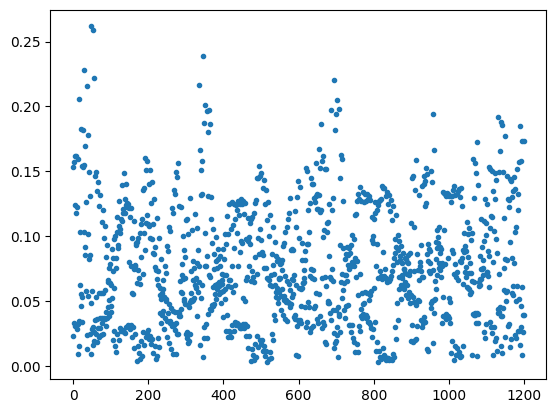

In [10]:
plt.plot(np.abs(DOFs),'.')

In [11]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

# Z = np.reshape(f(X.ravel(), Y.ravel()), [Ny,Nx]) FIX THIS, EVALUATION SHOULD BE VECTORIZED

u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
u_exact = np.reshape( GreenFunctionModes(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=100), (Ny,Nx))
# u_exact = np.reshape( GreenFunctionImages(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=80), (Ny,Nx))
# u_exact = np.exp(1j*np.emath.sqrt(kappa_e**2 - (t*np.pi/H)**2)*X)*np.cos(t*np.pi*Y/H)

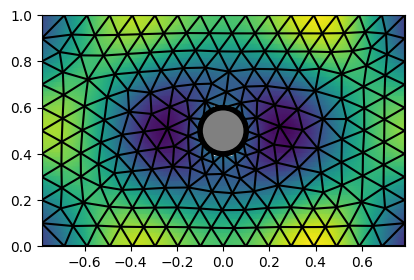

In [12]:

Domain.plot_field(X,Y,np.real(u_Trefft), show_edges=True)

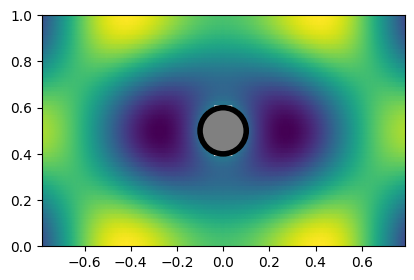

In [13]:
Domain.plot_field(X,Y,np.real(u_exact))

Text(0.5, 1.0, 'L2 error:  1.91e+01 %')

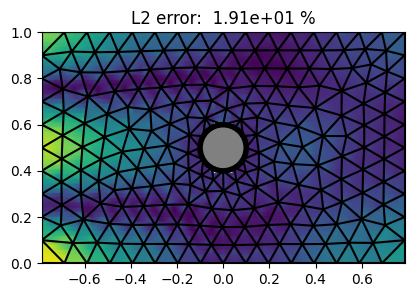

In [14]:
Domain.plot_field(X,Y,np.abs(u_Trefft-u_exact), show_edges=True)
plt.title(f'L2 error: {Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)*100 : .2e} %')


working on N=3...
h_max=0.4067989388936703
working on N=4...
h_max=0.3389150489561276
working on N=5...
h_max=0.2898130637277952
working on N=6...
h_max=0.236847643510049
working on N=7...
h_max=0.2030490519562134
working on N=8...
h_max=0.17665355176927594
working on N=9...
h_max=0.1566355529122445


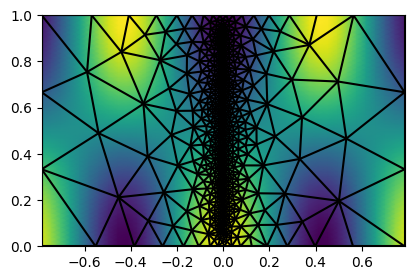

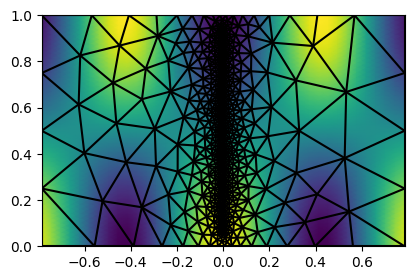

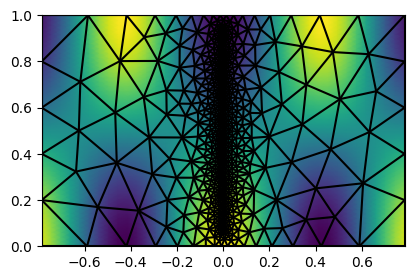

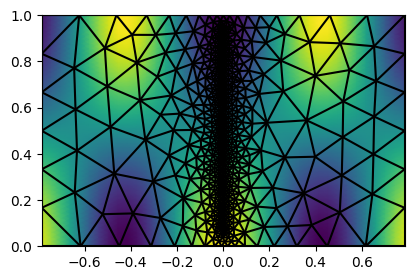

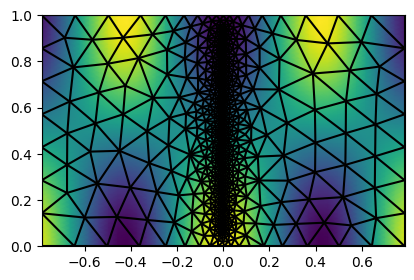

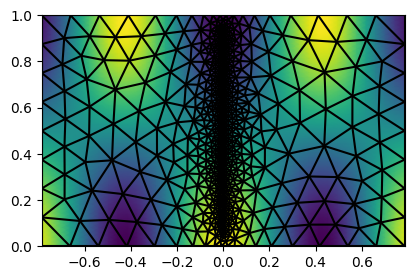

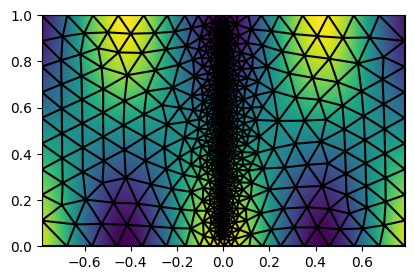

In [31]:
conds = []
hs = []
errors = []

kappa_e = 8.
lambda_e = 2*np.pi/kappa_e
R = lambda_e
H = 1.
c = (0,0.5*H)

t=1

Ny = 50
Nx = int(R/H*Ny)
x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)


for N in range(3,10):
    print(f"working on {N=}...")
    h = H/(N)
    hs.append(h)
    Domain = Waveguide(R=R,H=H)
    #Domain.add_scatterer( ScattererShape.CIRCLE, ScattererType.SOUND_SOFT, (c, 0.1*H))
    #Domain.add_scatterer( ScattererShape.RECTANGLE, ScattererType.SOUND_SOFT, (c, 0.2*H, 0.2*H))
    Domain.add_fine_mesh_region(h_min=0.01*H)
    Domain.generate_mesh(h_max=h)

    side_ls = np.array([E.l for E in Domain.Edges])
    h_max = np.max(side_ls)
    print(f'{h_max=}')

    Nth = 9
    th_0 = np.e/np.pi # no correct direction in the basis
    V = TrefftzSpace(Domain.Omega, Nth, {"Omega_i" : kappa_e , "Omega_e" : kappa_e}, th_0 )
    N_modes = 15 #Number of modes for the DtN map
    # "UWVF" parameters
    a = 0.5
    b = 0.5
    d_1 = 0.5
    d_2 = 0.5

    a = a*h_max/side_ls
    b = b*h_max/side_ls
    d_1 = d_1*h_max/side_ls
    d_2 = d_2*h_max/side_ls


    A = AssembleMatrix(V, Domain.Edges, H, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
    #conds.append(np.linalg.cond(A.toarray()))
    #B = AssembleGreenRHS(V, Domain.Edges, kappa_e, H, a=a, y0=c[1], modes=True)
    B = AssembleRHS(V, Domain.Edges, kappa_e, H, d_2=d_2, t = t)

    A = A.tocsc()
    DOFs = spsolve(A,B)
    f = TrefftzFunction(V,DOFs)

    u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
    u_exact = np.reshape( GreenFunctionModes(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=20), (Ny,Nx))
    #u_exact = np.reshape( GreenFunctionImages(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=100), (Ny,Nx))
    u_exact = np.exp(1j*np.emath.sqrt(kappa_e**2 - (t*np.pi/H)**2)*X)*np.cos(t*np.pi*Y/H)
    
    errors.append(Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)*100)
    Domain.plot_field(X,Y,np.real(u_Trefft), show_edges=True)



    
    

In [32]:
errors3 = errors
errors

[0.03951014915382778,
 0.0226557180788252,
 0.007418001852366505,
 0.004166437513216778,
 0.0020637232459611667,
 0.0012963867356239696,
 0.0006184378385422767]

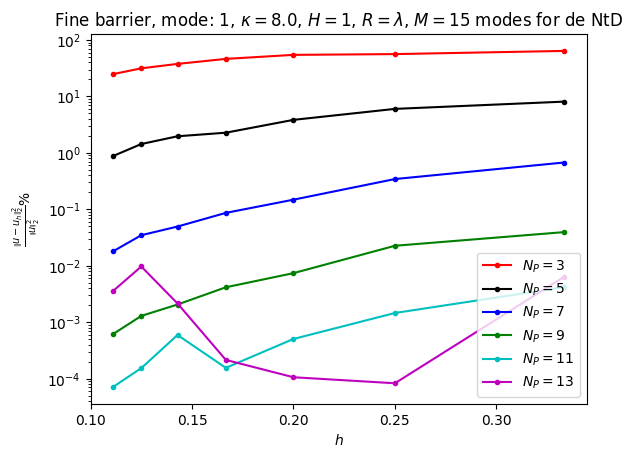

In [34]:
plt.semilogy(hs,errors0,'.-r', label=f'$N_P = 3$')
plt.semilogy(hs,errors1,'.-k', label=f'$N_P = 5$')
plt.semilogy(hs,errors2,'.-b', label=f'$N_P = 7$')
plt.semilogy(hs,errors3,'.-g', label=f'$N_P = 9$')
plt.semilogy(hs,errors4,'.-c', label=f'$N_P = 11$')
plt.semilogy(hs,errors5,'.-m', label=f'$N_P = 13$')
#plt.semilogy(hs,errors6,'.--r', label=f'$N_P = 15$')
plt.title(f'Fine barrier, mode: {t}, $\\kappa={kappa_e}$, $H = {H:.0f}$, $R = \\lambda$, $M={N_modes}$ modes for de NtD')
plt.xlabel('$h$')
plt.ylabel('$\\frac{\\left\\Vert u - u_h\\right\\Vert_2^2} {\\left\\Vert u \\right\\Vert_2^2}\\%$')
plt.legend()
plt.savefig('h-convergence_fine_mesh_barrier_rescaled.png')

In [92]:
V.N_DOF

3770

ValueError: x and y must have same first dimension, but have shapes (7,) and (0,)

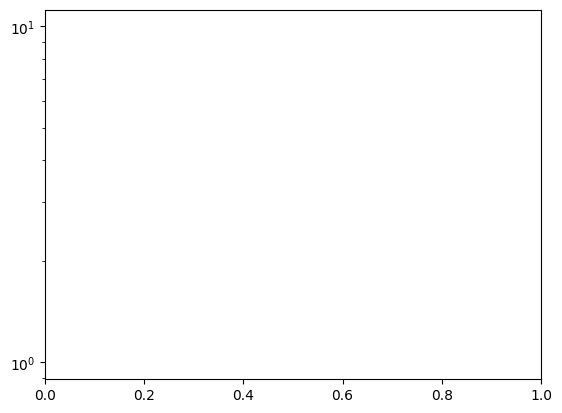

In [17]:
plt.semilogy(hs,conds,'.-')
plt.xlabel('h')

In [40]:
6*np.pi/H

18.84955592153876